<a href="https://colab.research.google.com/github/SaumilShah-7/Unintended-Bias-in-Toxicity-Classification-Kaggle/blob/master/Unintended_Bias_in_Toxicity_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torch.utils import data
import time
from tqdm.notebook import tqdm_notebook as tqdm
import pickle
from tensorflow.keras.preprocessing import text, sequence
import regex as re
from google.colab import files

max_features = 50000

def RAM_MAXOUT():
  a = []
  while(1):
    a.append('1')

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

 41% 5.00M/12.1M [00:00<00:00, 17.2MB/s]
100% 12.1M/12.1M [00:00<00:00, 30.7MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 73.5MB/s]
 96% 265M/276M [00:03<00:00, 71.2MB/s]
100% 276M/276M [00:03<00:00, 93.4MB/s]
100% 64.7M/64.7M [00:00<00:00, 40.1MB/s]

 73% 9.00M/12.3M [00:00<00:00, 23.9MB/s]
100% 12.3M/12.3M [00:00<00:00, 31.1MB/s]
 57% 9.00M/15.9M [00:00<00:00, 22.8MB/s]
100% 15.9M/15.9M [00:00<00:00, 39.6MB/s]
 32% 5.00M/15.8M [00:00<00:00, 31.8MB/s]
100% 15.8M/15.8M [00:00<00:00, 62.4MB/s]


In [0]:
!unzip -q -o train.csv.zip
!unzip -q -o test.csv.zip
!rm train.csv.zip
!rm test.csv.zip

In [16]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(1804874, 45)
(97320, 2)


In [3]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [5]:
!pip install Unidecode
from unidecode import unidecode

words_only = re.compile(r'[^A-Za-z\']')
def clean_text(x):
    x_ascii = unidecode(x)
    x_clean = words_only.sub(' ', x_ascii)
    return x_clean

train['clean_text'] = train['comment_text'].apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(lambda x: clean_text(x))

In [6]:
print(train['comment_text'][0])
print(train['clean_text'][0])

This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!
This is so cool  It's like  'would you want your mother to read this  ' Really great idea  well done 


In [7]:
print(len(train[train.comment_text.isna()]), len(test[test.comment_text.isna()]))

0 0


In [8]:
t = text.Tokenizer(num_words=max_features)
t.fit_on_texts(list(train['clean_text'])+list(test['clean_text']))

print(len(t.word_index))

344852


In [13]:
word_index = t.word_index
word_index

{'the': 1,
 'to': 2,
 'and': 3,
 'of': 4,
 'a': 5,
 'is': 6,
 'in': 7,
 'that': 8,
 'for': 9,
 'you': 10,
 'i': 11,
 'it': 12,
 'are': 13,
 'not': 14,
 'be': 15,
 'on': 16,
 'have': 17,
 'this': 18,
 'with': 19,
 'they': 20,
 'as': 21,
 'was': 22,
 'or': 23,
 'but': 24,
 'we': 25,
 'if': 26,
 'all': 27,
 'he': 28,
 'will': 29,
 'what': 30,
 'their': 31,
 'by': 32,
 'so': 33,
 'from': 34,
 'your': 35,
 'at': 36,
 'who': 37,
 'no': 38,
 'do': 39,
 'would': 40,
 'has': 41,
 'people': 42,
 'about': 43,
 'an': 44,
 'more': 45,
 'his': 46,
 'there': 47,
 'one': 48,
 'just': 49,
 'like': 50,
 'can': 51,
 'out': 52,
 'when': 53,
 'up': 54,
 'trump': 55,
 'our': 56,
 "don't": 57,
 'how': 58,
 'them': 59,
 'my': 60,
 'get': 61,
 "it's": 62,
 'should': 63,
 'than': 64,
 'us': 65,
 'been': 66,
 'were': 67,
 'only': 68,
 'time': 69,
 'any': 70,
 'some': 71,
 'because': 72,
 'other': 73,
 'now': 74,
 'think': 75,
 'those': 76,
 'why': 77,
 'many': 78,
 'know': 79,
 'good': 80,
 'then': 81,
 'which':

In [10]:
X_train = t.texts_to_sequences(train['clean_text'])
X_test = t.texts_to_sequences(test['clean_text'])

l = list(map(len, X_train))
print('Min: %d, Mean: %d, Q3: %d, Max: %d' %(min(l), sum(l)/len(l), np.percentile(l, 75), max(l)))

Min: 0, Mean: 50, Q3: 71, Max: 311


In [11]:
MAX_LEN = 150

x_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']]

print(x_train.shape, x_test.shape, y_train.shape, y_aux_train.shape)

(1804874, 150) (97320, 150) (1804874,) (1804874, 7)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(array([0, 1]), array([1660540,  144334]))


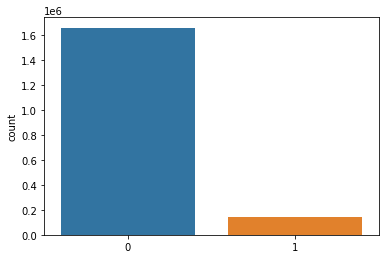

In [12]:
import seaborn as sns
sns.countplot(y_train)
print(np.unique(y_train, return_counts=True))

In [0]:
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_aux_train.npy', y_aux_train)

with open('word_index.pickle', 'wb') as handle:
  pickle.dump(word_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

RAM_MAXOUT()

In [18]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2020-05-31 15:11:03--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  34.5MB/s    in 43s     

2020-05-31 15:11:47 (33.5 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

--2020-05-31 15:11:48--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-05-31 15:11:48--  https://nlp.stanfor

In [0]:
!unzip -q -o crawl-300d-2M.vec.zip 
!unzip -q -o glove.840B.300d.zip
!rm crawl-300d-2M.vec.zip
!rm glove.840B.300d.zip

In [0]:
def get_coefs(word,*arr):
  return word, np.asarray(arr, dtype='float32')

embeddings_index_ft = dict(get_coefs(*o.strip().split()) for o in open('crawl-300d-2M.vec'))
embeddings_index_gl = dict(get_coefs(*o.strip().split(' ')) for o in open('glove.840B.300d.txt'))

In [8]:
with open('word_index.pickle', 'rb') as handle:
 word_index = pickle.load(handle)

nb_words = min(max_features, len(word_index))
word_process = re.compile(r'[^A-Za-z]')
corrected = []
words_not_found = []

def build_matrix(embedding, nb_words, embed_size):
  matrix = np.zeros((nb_words, embed_size))
  for word, i in word_index.items():
    if i >= nb_words:
      break
    else:
      if embedding.get(word) is not None:
        matrix[i]=embedding.get(word)
      else:
        word2 = word_process.sub('', word)
        if embedding.get(word2) is not None:
          matrix[i]=embedding.get(word2)
          corrected.append((word, word2))
        else:
          words_not_found.append(word)
  return matrix

embedding_matrix = np.concatenate((build_matrix(embeddings_index_ft, nb_words, 300), build_matrix(embeddings_index_gl, nb_words, 300)), 
                                  axis=-1)
corrected= list(set(corrected))
words_not_found= list(set(words_not_found))

print(embedding_matrix.shape)                               

(50000, 600)


In [10]:
print(len(words_not_found))
print(words_not_found)

print(len(corrected))
print(corrected)

3398
['moyane', 'rasmusson', "iowa's", 'callista', 'manahan', 'kawananakoa', 'miano', 'kapalama', 'ainokea', 'tradingeconomics', 'cfcs', 'firstthings', 'dlnr', 'cupich', 'kalaheo', 'newsbusters', "trudope's", "bmo's", 'prevo', 'sjsj', 'mcgugan', 'tongass', 'blatchford', 'murkowski', 'tokuda', "cpc's", "quada's", 'hoquiam', "coghill's", 'hkrieger', 'strombo', 'eugenes', 'hoffbeck', "marx's", 'kadhr', 'atheo', 'mcdougals', "cupich's", 'altright', 'cfius', 'balkisoon', "wohlforth's", 'norquist', 'honua', 'putins', 'viewcontent', 'olrun', 'alutiiq', 'drumph', 'hominen', 'governmint', 'carberry', 'yuuuge', 'krook', 'hannemann', "haycox's", "columbia's", 'donlin', "zippy's", 'wuwt', 'murcowski', "o'rourke", "scotia's", 'haleakala', 'hatefi', 'bannons', 'cretien', 'preez', 'motherjones', "moscow's", 'khosa', 'mmusi', "lille's", 'menelik', 'zululand', 'musser', 'bernardin', 'girdwood', "ctv's", "msnbc's", 'repubes', 'monforts', 'fiberals', 'chumpty', 'landow', 'mercurynews', 'opala', 'governor

In [0]:
np.save('embedding_matrix.npy', embedding_matrix)

RAM_MAXOUT()

In [0]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_aux_train = np.load('y_aux_train.npy')
embedding_matrix = np.load('embedding_matrix.npy')

In [0]:
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

class SpatialDropout(nn.Dropout2d):
  def forward(self, x):
    x = x.unsqueeze(2)    # (N, T, 1, K)
    x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
    x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
    x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
    x = x.squeeze(2)  # (N, T, K)
    return x
    
class NeuralNet(nn.Module):
  def __init__(self, embedding_matrix, num_aux_targets):
    super(NeuralNet, self).__init__()
    embed_size = embedding_matrix.shape[1]

    self.embedding = nn.Embedding(max_features, embed_size)
    self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False
    self.embedding_dropout = SpatialDropout(0.3)

    self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
    self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

    self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
    self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)

    self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
    self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
  def forward(self, x):
    h_embedding = self.embedding(x)
    h_embedding = self.embedding_dropout(h_embedding)

    h_lstm1, _ = self.lstm1(h_embedding)
    h_lstm2, _ = self.lstm2(h_lstm1)

    avg_pool = torch.mean(h_lstm2, 1)
    max_pool, _ = torch.max(h_lstm2, 1)

    h_conc = torch.cat((max_pool, avg_pool), 1)
    h_conc_linear1  = F.relu(self.linear1(h_conc))
    h_conc_linear2  = F.relu(self.linear2(h_conc))

    hidden = h_conc + h_conc_linear1 + h_conc_linear2

    result = self.linear_out(hidden)
    aux_result = self.linear_aux_out(hidden)
    out = torch.cat([result, aux_result], 1)

    return out

In [0]:
# model = NeuralNet(embedding_matrix, 7)
# summary(model, (1, 5, 150))

In [0]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def train_model(model, train, test, loss_fn, output_dim, lr=0.001, batch_size=512, n_epochs=4, enable_checkpoint_ensemble=True):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
  all_test_preds = []
  
  checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
  for epoch in range(n_epochs):
    start_time = time.time()

    scheduler.step()
    model.train()
    avg_loss = 0.
    
    for data in tqdm(train_loader, disable=False):
      x_batch = data[:-1]
      y_batch = data[-1]
      
      y_pred = model(*x_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_loss += loss.item() / len(train_loader)
      # print(len(train_loader))
      
    model.eval()
    test_preds = np.zeros((len(test), output_dim))
    
    for i, x_batch in enumerate(test_loader):
      y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())
      test_preds[i*batch_size:(i+1)*batch_size] = y_pred

    all_test_preds.append(test_preds)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(epoch+1, n_epochs, avg_loss, elapsed_time))

  if enable_checkpoint_ensemble:
      test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
  else:
      test_preds = all_test_preds[-1]
      
  return test_preds

In [15]:
def seed_everything(seed=1234):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()

train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch)

all_test_preds = []

for model_idx in range(NUM_MODELS):
  print('Model ', model_idx)
  seed_everything(1234 + model_idx)
  
  model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
  model.cuda()
  test_preds = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
  all_test_preds.append(test_preds)

Model  0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 1/4 	 loss=0.1018 	 time=425.75s



Epoch 2/4 	 loss=0.0952 	 time=426.32s



Epoch 3/4 	 loss=0.0940 	 time=428.82s



Epoch 4/4 	 loss=0.0933 	 time=426.10s
Model  1



Epoch 1/4 	 loss=0.1020 	 time=425.27s



Epoch 2/4 	 loss=0.0953 	 time=425.53s



Epoch 3/4 	 loss=0.0941 	 time=426.79s



Epoch 4/4 	 loss=0.0934 	 time=424.27s


In [0]:
submission = pd.DataFrame({'id': test['id'], 'prediction': np.mean(all_test_preds, axis=0)[:, 0]})
submission.to_csv('submission.csv', index=False)
files.download('submission.csv') 